In [1]:
!pip install git+git://github.com/linalgo/linalgo-sdk.git requests pillow

  Cloning git://github.com/linalgo/linalgo-sdk.git to /tmp/pip-req-build-nk2rjrqm
  Running command git clone -q git://github.com/linalgo/linalgo-sdk.git /tmp/pip-req-build-nk2rjrqm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import requests, io
from PIL import Image

from linalgo.annotate.models import Document, Annotation, Entity
from linalgo.hub.client import LinalgoClient
from linalgo.annotate.bbox import draw_bounding_boxes

In [4]:
client = LinalgoClient(token=My_Token, api_url='https://prod.linhub.api.linalgo.com/v1')
task = client.get_task('a9b4a03b-3af5-476f-8656-c69a32ea9866', verbose=True)

Retrivieving task with id a9b4a03b-3af5-476f-8656-c69a32ea9866...
Retrieving annotators... (9 found)
Retrieving entities... (8 found)
Retrieving documents... (348 found)
Retrieving annotations... (35049 found)


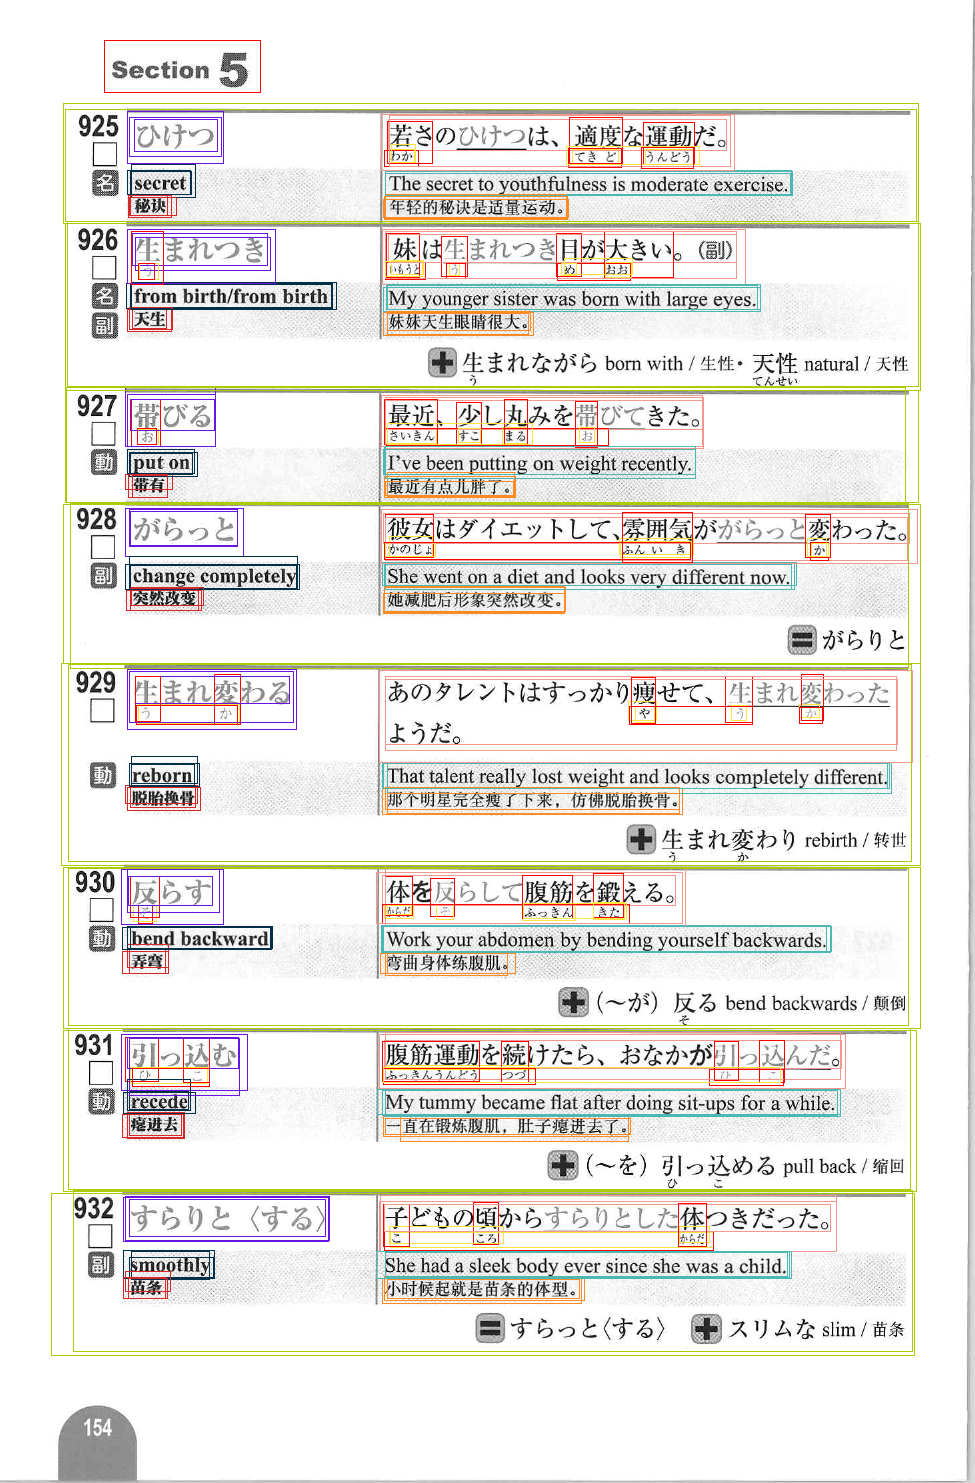

In [5]:
doc = task.documents[0]
response = requests.get(doc.content)
img = Image.open(io.BytesIO(response.content))
draw_bounding_boxes(img, doc.annotations)

In [6]:
doc.annotations 
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

In [7]:
doc.content

'https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-160.png'

In [8]:
len(task.documents)

348

In [9]:
task.documents[0].annotations[3].target.selectors

[{(70.1027981667144, 503.44106140422787), (908.9565846710537, 503.44106140422787), (908.9565846710537, 668.3550411039973), (70.1027981667144, 668.3550411039973)}]

New features: 
Compute distance of boxes with item box. 
Change features to give information relative to the box. 
Associate other bounding box to the item box. 
Compute new features. 
One less class. 

Compute distance of all boxes and identify which box is the closest. 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
ent_list =[]
coord_list = []
doc_list = []
for i in range(len(task.documents)): 
    document = task.documents[i]
    for ant in range(len(document.annotations)): 
        annotation = document.annotations[ant]
        entity = annotation.entity.name
        coordinates = annotation.target.selectors[0]
        ent_list.append(entity)
        coord_list.append(coordinates)
        doc_list.append(document.content)

In [12]:
top= []
bottom=[]
left=[]
right=[]
area = []
width=[]
height=[]

for i in range(len(coord_list)):
    top.append(coord_list[i].top)
    bottom.append(coord_list[i].bottom)
    left.append(coord_list[i].left)
    right.append(coord_list[i].right)
    area.append(coord_list[i].area)
    width.append(coord_list[i].width)
    height.append(coord_list[i].height)

In [13]:
pd.options.display.max_colwidth = 200
elem = {'Entity': ent_list, 'document_id': doc_list}
df= pd.DataFrame(elem)
df.columns = ['Entity', 'document_id']

df['document_no'] = df.groupby(['document_id']).ngroup()

df['top'] = pd.DataFrame(top)
df['bottom'] = pd.DataFrame(bottom)
df['left'] = pd.DataFrame(left)
df['right'] = pd.DataFrame(right)
df['area'] = pd.DataFrame(area)
df['width'] = pd.DataFrame(width)
df['height'] = pd.DataFrame(height)

df = df.sort_values(by=['document_no', 'top'])
df['entity_count'] = df.groupby(['document_id', 'Entity']).cumcount()
df = df.reset_index(drop=True)
df.head()

,Entity,document_id,document_no,top,bottom,left,right,area,width,height,entity_count
0,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-001.png,0,107.952941,696.470588,156.705882,921.082353,449849.041938,764.376471,588.517647,0
1,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-001.png,0,192.708340,563.925457,176.074573,908.366265,271839.210901,732.291691,371.217118,1
2,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-002.png,1,844.000000,1002.000000,215.600006,281.600006,10428.000000,66.000000,158.000000,0
3,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-003.png,2,1161.091048,1278.824056,231.000288,322.344863,10754.271659,91.344575,117.733008,0
4,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-004.png,3,1228.077070,1319.421645,170.103904,267.538118,8900.086890,97.434214,91.344575,0


In [14]:
len(df)
df = df.drop_duplicates() # Remove duplicates
len(df)

35049

In [15]:
df = df.dropna()
df.isnull().sum().sort_values(ascending=False)

Entity          0
document_id     0
document_no     0
top             0
bottom          0
left            0
right           0
area            0
width           0
height          0
entity_count    0
dtype: int64

In [16]:
keep_df = df[df['Entity'] == 'word-jp']
keep_s = keep_df.document_no.reset_index(drop=True).tolist()
df = df[df['document_no'].isin(keep_s)]
len(df)

34790

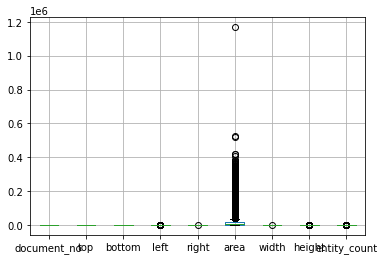

In [17]:
df.boxplot();

In [18]:
df.describe()

,document_no,top,bottom,left,right,area,width,height,entity_count
count,34790.000000,34790.000000,34790.000000,34790.000000,34790.000000,3.479000e+04,34790.000000,34790.000000,34790.000000
mean,160.573239,681.437787,725.180840,248.196330,556.181779,2.194127e+04,307.985449,43.743053,9.431417
std,82.845382,345.275948,345.268906,146.672659,293.927332,4.290780e+04,251.092059,45.128344,8.226688
min,17.000000,100.135135,133.084252,7.718756,94.369855,5.423352e-01,0.736434,0.736434,0.000000
25%,88.000000,387.078234,432.395294,128.769093,234.825428,2.422513e+03,93.176405,20.038536,4.000000
50%,163.000000,666.972656,711.425692,140.650574,624.955677,5.771926e+03,228.339238,24.319999,8.000000
75%,234.000000,972.889412,1018.221176,385.320000,856.650588,1.681887e+04,469.325882,49.290464,13.000000
max,319.000000,1401.562547,1463.226667,888.636626,2280.279739,1.167503e+06,1565.702326,745.673699,92.000000


In [19]:
outlier = df[df.area ==df.area.max()].index
df.drop(outlier , inplace=True)
# check = df[df.area ==df.area.max()]
# pd.options.display.max_colwidth = 200
# check

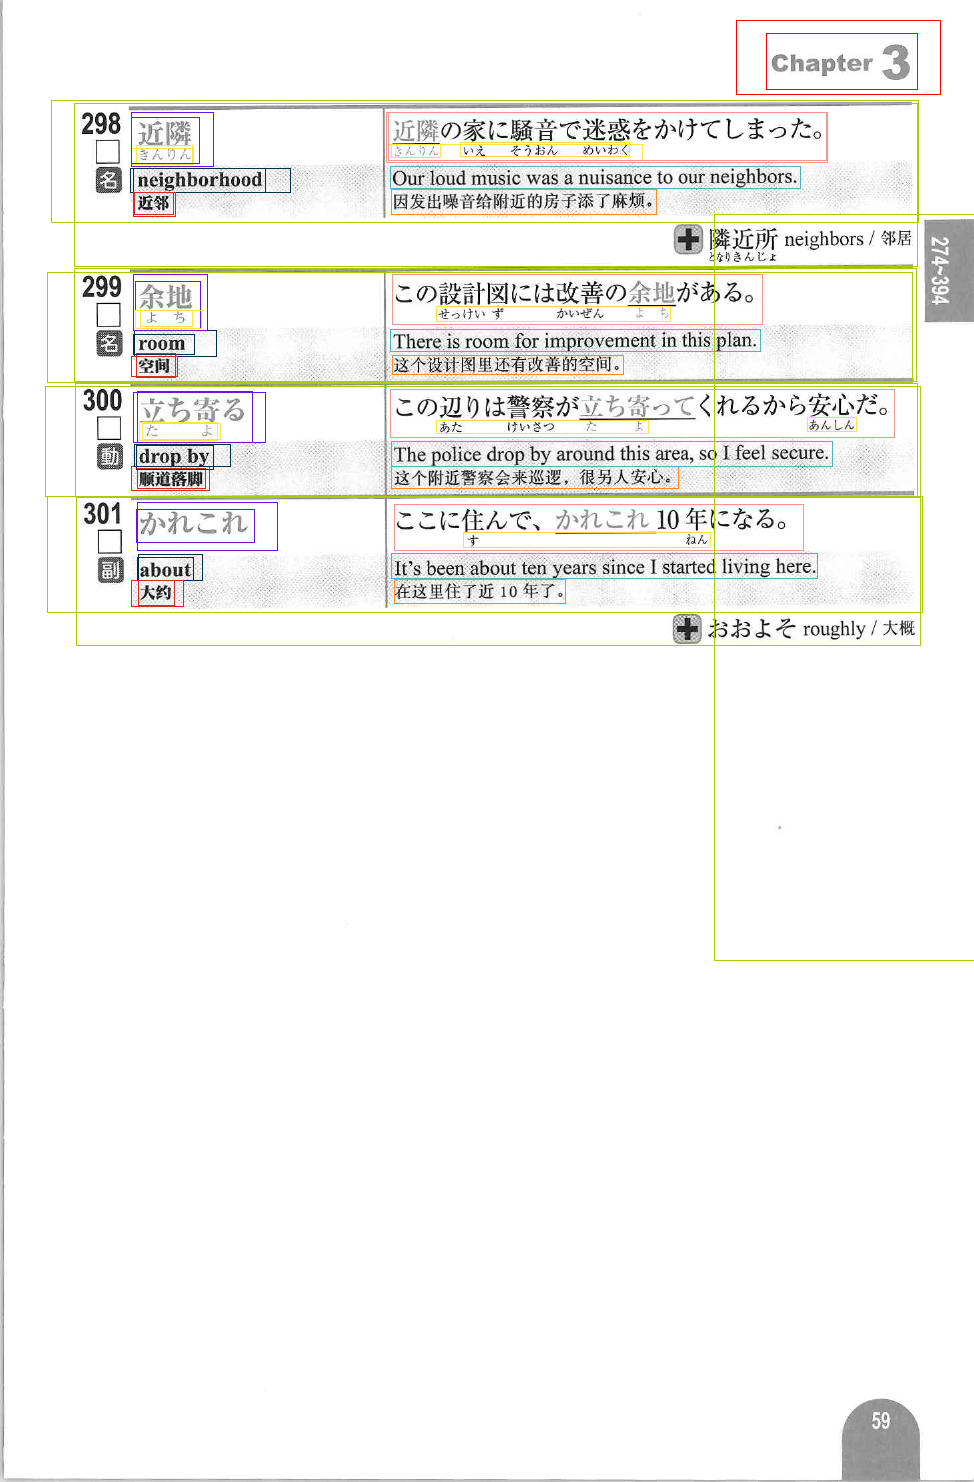

In [20]:
doc_61 = task.documents[13]
response_61 = requests.get(doc_61.content)
img_61 = Image.open(io.BytesIO(response_61.content))
draw_bounding_boxes(img_61, doc_61.annotations)

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mmscaler = MinMaxScaler()
ssscaler = StandardScaler()

cols = ['top', 'bottom', 'left', 'right', 'area', 'width', 'height']

# df[cols] = mmscaler.fit_transform(df[cols])
df[cols] = ssscaler.fit_transform(df[cols])

df.head()

,Entity,document_id,document_no,top,bottom,left,right,area,width,height,entity_count
26,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,-1.286458,-0.933038,-1.204558,1.302053,2.868512,2.227754,2.713388,0
27,item,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,-1.277770,-0.938978,-1.107921,1.227453,2.628825,2.083978,2.601084,1
28,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,-1.266245,-1.241284,0.936896,0.921971,0.028155,0.531715,0.191641,0
29,sent-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,-1.261339,-1.239820,0.925566,0.744778,-0.044900,0.330941,0.165217,1
30,word-jp,https://storage.googleapis.com/book-extraction-linalgo-com/はじめての日本語能力試験 N1単語3000/cd52a5fd-7120-49fc-b07a-aefd63877960-018.png,17,-1.256138,-1.226125,-0.800061,-1.037826,-0.362578,-0.747265,0.230437,0


In [23]:
df.Entity.value_counts()

furi       7566
item       3934
word-jp    3913
word-zh    3908
sent-en    3882
sent-jp    3878
sent-zh    3865
word-en    3843
Name: Entity, dtype: int64

In [24]:
baseline_model = 7566/len(df.Entity)*100
baseline_model

21.7482537583719

<AxesSubplot:>

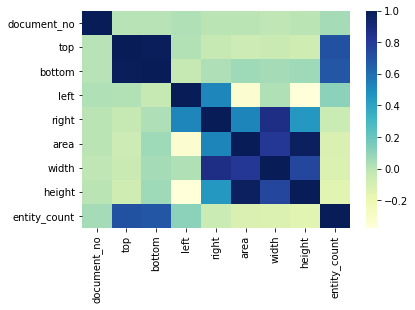

In [25]:
import seaborn as sns

# Heatmap
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [26]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
11,top,bottom,0.991517
19,bottom,top,0.991517
68,height,area,0.973117
52,area,height,0.973117
42,right,width,0.866582


In [29]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.3)
X_train = train_data.drop(['Entity', 'document_id', 'document_no', 'entity_count'], axis = 1)
y_train = train_data.Entity
X_test = test_data.drop(['Entity','document_id', 'document_no', 'entity_count'], axis = 1)
y_test = test_data.Entity
X_train, len(X_train), len(X_test)

(            top    bottom      left     right      area     width    height
 28329 -1.111263 -1.173869 -0.847848 -0.844363 -0.419996 -0.492907 -0.480651
 24190 -1.631069 -1.614945 -0.874474 -1.009374 -0.353804 -0.670486  0.123804
 7321   0.312897  0.335925  0.868764  1.306722  0.170915  1.021850  0.176797
 264   -1.170234 -1.195806 -0.788164 -1.037826 -0.418418 -0.754216 -0.196320
 29453  1.356371  1.689579 -1.383012  1.212971  2.726010  2.227754  2.558204
 ...         ...       ...       ...       ...       ...       ...       ...
 2216   0.215587  0.630178 -1.162188  1.242561  3.195517  2.133367  3.183025
 26011  0.640902  0.560334 -0.828506 -1.256069 -0.493266 -0.986085 -0.618563
 25627  1.215151  1.157592 -0.799372 -0.770753 -0.404286 -0.435075 -0.441917
 17674  1.619366  1.539895  1.525596 -0.097564 -0.494601 -1.005546 -0.610153
 25374 -0.983933 -1.041218  0.925612  0.221111 -0.382177 -0.282005 -0.439799
 
 [24352 rows x 7 columns],
 24352,
 10437)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=8)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.8573344830890103

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score
neigh_results = cross_validate(neigh, X_train, y_train, cv=5, scoring="accuracy")
neigh_results_f1 = cross_validate(neigh, X_train, y_train, cv=5, scoring="f1_weighted")

neigh_results['test_score'].mean(), neigh_results_f1['test_score'].mean()

(0.8484313944532806, 0.8489110996686773)

In [32]:
from sklearn.model_selection import learning_curve

train_sizes = [750,1000, 2000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 19000]
train_sizes, train_scores, test_scores = learning_curve(
    estimator=neigh, X=X_train, y=y_train, train_sizes=train_sizes, cv=5, scoring="accuracy")

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

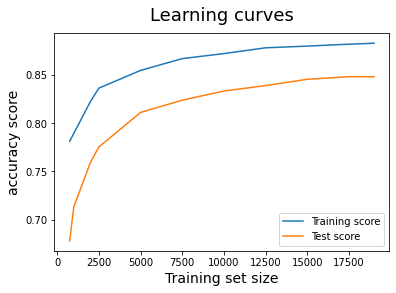

In [33]:
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('accuracy score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();

Random forest at 10,000 train set size

Curves does not converge, so model is still learning. 

You can use data augmentation to increase the number of data points to better train model. 
Data augmentation (like mirror, crop, etc.)

In [34]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

lin_svc = LinearSVC(random_state=0, max_iter=10500)
lin_svc.fit(X_train, y_train)
lin_svc.score(X_test, y_test)

0.8054038516815176

In [35]:
lin_svc_results = cross_validate(lin_svc, X_train, y_train, cv=5, scoring="accuracy")
lin_svc_results['test_score'].mean()

0.8058067336459294

In [36]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=8)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

rfc_results = cross_validate(rfc, X_train, y_train, cv=5, scoring="accuracy")
rfc_results['test_score'].mean()

0.8616537551793142

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),
                               n_estimators=100)    
abc.fit(X_train, y_train)
abc.score(X_test, y_test)

abc_results = cross_validate(abc, X_train, y_train, cv=5, scoring="accuracy")
abc_results['test_score'].mean()

0.8415321453668929

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

gbc_results = cross_validate(abc, X_train, y_train, cv=5, scoring="accuracy")
gbc_results['test_score'].mean()

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric= 'merror', early_stopping_rounds=5) 
xgb_results = cross_validate(xgb, X_train, y_train, cv=5, scoring="accuracy")
xgb_results['test_score'].mean()

In [60]:
1- 0.11326

0.88674